ns 1
ns 2
ns 3
ns 4
ns 5
ns 6
ns 7
ns 8
ns 9
ns 10
ns 11
ns 12
ns 13
ns 14
ns 15
ns 16
ns 17
ns 18
ns 19
ns 20
ns 21
ns 22
ns 23
ns 24
ns 25
ns 26
ns 27
ns 28
ns 29
ns 30


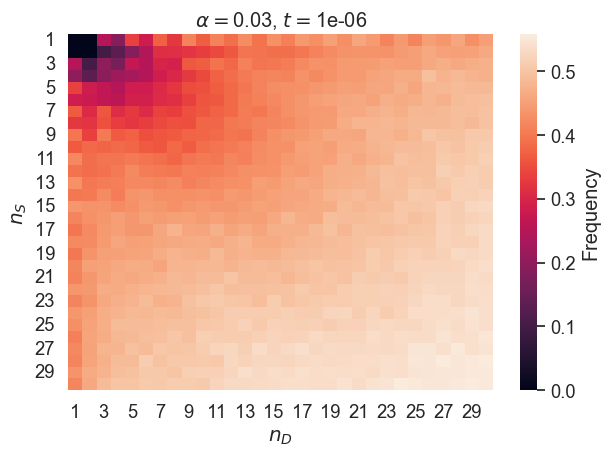

In [3]:
# Import required libraries
import matplotlib.pyplot as plt
import numpy as np
import numba as nb
import pandas as pd
import seaborn as sns


# Check if a list is non-increasing with an epsilon tolerance
def non_increasing(L, epsilon):
    return all(x+epsilon>=y for x, y in zip(L, L[1:]))


# Check if a list is non-decreasing with an epsilon tolerance
def non_decreasing(L, epsilon):
    return all(x-epsilon<=y for x, y in zip(L, L[1:]))


# Check if a list is monotonic (either increasing or decreasing) with an epsilon tolerance
def monotonic(L, epsilon):
    return non_increasing(L, epsilon) or non_decreasing(L, epsilon)


@nb.njit()
def analytics(t, fs, fd, mus, mud):
    ns = len(fs)
    nd = len(fd)
    Ps = np.zeros(ns+1)
    Pd = np.zeros(nd)

    fs[::-1].sort()
    fd[::-1].sort()

    for i in range(ns):
        Ps[i] = (1 - np.exp(-t * mus)) * np.exp(-t * mus * i)
    Ps[ns] = np.exp(-t * mus *ns)

    for i in range(nd):
        Pd[i] = (1 - np.exp(-t * mud)) * np.exp(-t * mud * i)

    H = np.zeros((ns+1, nd))
    for i in range(ns):
        for j in range(nd):
            H[i, j] = fs[i] < fd[j]
    H[ns] = 1

    FD = np.dot(Ps,np.dot(H, Pd))/(1-np.exp(-t*(ns*mus+nd*mud)))
    #FD = np.dot(Ps,np.dot(H, Pd))

    return FD


# Parameter initializations
alpha = 4.1*10**(-3)
mus = 1
mud = 1*alpha
gridpoints = 30
landscapes = 10000
datapoints = 60
min_ns = 1
min_nd = 1
max_ns = 30
max_nd = 30
threshold = 0.000001  #0.001

# Create lists for different values of ns and nd
ns_list = np.linspace(min_ns, max_ns, num=gridpoints, dtype=int)
nd_list = np.linspace(min_nd, max_nd, num=gridpoints, dtype=int)

# Create an empty DataFrame to store results
df = pd.DataFrame(columns=['$n_S$','$n_D$','fraction'])

# Loop through different values of ns and nd to compute fractions
for ns_i in ns_list:
    print("ns", ns_i)
    for nd_i in nd_list:

        # Determine tmin and tmax based on mutation rates and ns and nd values
        if 0.1 / (mus * ns_i) <= 0.1 / (mud * nd_i):
            tmin = 0.1 / (mus * ns_i)
        else:
            tmin = 0.1 / (mud * nd_i)

        if 5 * nd_i / (mud * nd_i) >= 5 * ns_i / (mus * ns_i):
            tmax = 5 * nd_i / (mud * nd_i)
        else:
            tmax = 5 * ns_i / (mus * ns_i)

        T = np.logspace(np.log10(tmin), np.log10(tmax), num=datapoints, base=10)  # mutation supply
        all_y = np.zeros((landscapes, datapoints))

        for l in range(landscapes):
            fs = np.random.random(size=ns_i)
            fd = np.random.random(size=nd_i)

            y = np.zeros(len(T))
            for i in range(len(T)):
                y[i] = analytics(T[i], fs, fd, mus, mud)
            all_y[l] = y

        fraction = 0
        for i in range(landscapes):
            a_temp = monotonic(all_y[i], threshold)
            if a_temp == False:
                fraction += 1
                x = all_y[i]

                f = nd_i*mud/(nd_i*mud+ns_i*mus)

        new_row = pd.Series({'$n_S$': ns_i, '$n_D$': nd_i, 'fraction':fraction/landscapes})
        df = pd.concat([df, new_row.to_frame().T], ignore_index=True)


df["$n_S$"] = df["$n_S$"].astype(int)
df["$n_D$"] = df["$n_D$"].astype(int)

#df = df.pivot("$n_S$", "$n_D$", "fraction")
df = df.pivot(index='$n_S$', columns='$n_D$', values='fraction')

# Plot heatmap
sns.set(font_scale=1.2)
sns.heatmap(df, cbar_kws={'label': 'Frequency'})
plt.yticks(rotation=0)
plt.xlabel("$n_D$")
plt.ylabel("$n_S$")
plt.title('$\\alpha=${}, $t=${}'.format(alpha, threshold))

plt.tight_layout()
plt.show()